# `Featurization` - FamilySize

In [1]:
from src.utils import load_data
import pandas as pd
dfX, dfy = load_data(return_X_y=True)

In [2]:
def adder(df):
    return pd.DataFrame(df.sum(axis=1))

In [3]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import clone
add_columns = FunctionTransformer(adder)
family_size = clone(add_columns)

def get_feature_names(self):
    return 'FamilySize'

family_size.get_feature_names = get_feature_names

In [4]:
family_size.fit_transform(dfX.loc[:, ['SibSp', 'Parch']])

,0
0,1
1,1
2,0
3,1
4,0
...,...
886,0
887,0
888,3
889,0


## Let's try it in a pipeline (dp1)

In [5]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [6]:
imp_enc = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('enc', OneHotEncoder(drop='first'))
])

clmn_trnsfrm = ColumnTransformer([
    ('clmn_drp', 'drop', ['Name', 'Ticket', 'Cabin']),
    ('enc', OneHotEncoder(drop='first'), ['Sex']),
    ('imp_enc', imp_enc, ['Embarked']),
    ('imp', SimpleImputer(), ['Age', 'Fare']),
    ('pass', 'passthrough', ['SibSp', 'Parch']),
    ('familysize', family_size, ['SibSp', 'Parch'])
], 'passthrough')


preprocess_data = Pipeline([
    ('clmn_trnsfrm', clmn_trnsfrm),
    ('scale', StandardScaler())
])

In [9]:
from src.featurization import NameTitleExtractor, CabinTypeExtractor, TicketTypeExtractor
from src.featurization import SibSpBinner, ParchBinner


imp_enc = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('enc', OneHotEncoder(drop='first'))
])


preprocess_noscale = ColumnTransformer([
    ('enc', OneHotEncoder(drop='first'), ['Sex']),
    ('imp_enc', imp_enc, ['Embarked']),
    ('imp', SimpleImputer(), ['Age', 'Fare']),
    ('pre_Name', NameTitleExtractor(), 'Name'),
    ('pre_Cabin', CabinTypeExtractor(), 'Cabin'),
    ('pre_Ticket', TicketTypeExtractor(), 'Ticket'),
    ('Pre_SibSp', SibSpBinner(), ['SibSp']),
    ('Pre_Parch', ParchBinner(), ['Parch']),
    ('familysize', family_size, ['SibSp', 'Parch'])
], 
    'passthrough')

preprocess_data = Pipeline([
    ('clmn_trnsfrm', preprocess_noscale),
    ('scale', StandardScaler())
])


In [10]:
preprocess_data.fit_transform(dfX).shape

(891, 26)

In [11]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
skf = StratifiedKFold()

In [12]:
def get_training_cv_score(pipe, dfX, dfy):
    print(f'Training score: {pipe.score(dfX, dfy)}')
    print(f'crossvalidation score: {cross_val_score(pipe, dfX, dfy, cv=skf).mean()}')

In [13]:
mlmodel = RandomForestClassifier()
pipe = Pipeline([
    ('preprocess', preprocess_data),
    ('ml', mlmodel)
])
pipe.fit(dfX, dfy)
get_training_cv_score(pipe, dfX, dfy)

Training score: 1.0
crossvalidation score: 0.8092398468394952


## Let's check if adding this feature helped

In [14]:
def get_best_param_score(search):
    print(f'Best param: {search.best_params_}')
    print(f'Best score: {search.best_score_}')

In [16]:
param_grid = {'preprocess__clmn_trnsfrm__familysize': [family_size, 'drop']}
search = GridSearchCV(pipe, param_grid, cv=skf)
search.fit(dfX, dfy)
get_best_param_score(search)

Best param: {'preprocess__clmn_trnsfrm__familysize': 'drop'}
Best score: 0.8148327160881301


### So we got the best score when we dropped both i.e. didn't include SibSp and Parch and also didn't add FamilySize

In [161]:
res = pd.DataFrame(search.cv_results_)
res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocess__clmn_trnsfrm__familysize,param_preprocess__clmn_trnsfrm__pass,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.025853,0.005915,0.008016,0.000773,"FunctionTransformer(accept_sparse=False, check...",drop,{'preprocess__clmn_trnsfrm__familysize': Funct...,0.810056,0.820225,0.808989,0.797753,0.842697,0.815944,0.015153,4
1,0.024351,0.000693,0.007805,0.000325,"FunctionTransformer(accept_sparse=False, check...",passthrough,{'preprocess__clmn_trnsfrm__familysize': Funct...,0.815642,0.820225,0.820225,0.808989,0.837079,0.820432,0.009285,2
2,0.020870,0.000876,0.006584,0.000582,drop,drop,{'preprocess__clmn_trnsfrm__familysize': 'drop...,0.804469,0.831461,0.848315,0.792135,0.831461,0.821568,0.020346,1
3,0.022072,0.000623,0.008098,0.000661,drop,passthrough,{'preprocess__clmn_trnsfrm__familysize': 'drop...,0.821229,0.820225,0.814607,0.797753,0.848315,0.820426,0.016287,3


## Let's compare these scores

In [164]:
familysize_labs = (res['param_preprocess__clmn_trnsfrm__familysize']
                   .apply(lambda x: x if x == 'drop' else 'familysize')
                  )

labs = (familysize_labs.str.cat(res['param_preprocess__clmn_trnsfrm__pass'], sep=' + '))
labs = labs[res['rank_test_score'].sort_values().index]

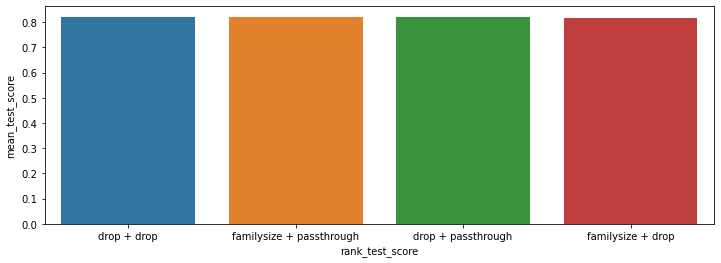

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
g = sns.barplot(x='rank_test_score', y='mean_test_score', data=res)
g.set_xticklabels(labs);

### So we got the best score when we dropped both i.e. didn't include SibSp and Parch and also didn't add FamilySize